<a href="https://colab.research.google.com/github/FKhadivpour/Time-series-analysis/blob/main/Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Load Data

In [ ]:
from pandas.compat.numpy import np_array_datetime64_compat
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import datetime
from matplotlib import rcParams
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from pandas.plotting import autocorrelation_plot
import plotly.graph_objects as go
import plotly.express as px
import tensorflow as tf
# import IPython
# import IPython.display
from sklearn.metrics import mean_absolute_error


In [ ]:
dataset = pd.read_csv('/power_data.csv', 
                       parse_dates=["Datetime"],
                      index_col=0,
                      )
# dataset.drop('Unnamed: 0', axis=1, inplace=True)
dataset.head()

,Datetime,Power_MWH
0,2010-01-01 00:00:00,31647.0
1,2010-12-31 01:00:00,29634.0
2,2010-12-31 02:00:00,28614.0
3,2010-12-31 03:00:00,28146.0
4,2010-12-31 04:00:00,28051.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Pre Processing

For the initial data **preprocessing**, we should take some steps:


*   **Null values:** Look at the number of missing values in the data to further fill them with an appropriate method. There were no null values in the dataset. 
*   **Duplicate values:** Look at the number of duplicate rows or duplicate datetimes to further remove them with an appropriate method. There were no duplicate rows in the dataset. We replaced 4 pairs of duplicate datetime values with the average of each pair. 
*   **Missing datetimes:** We should have 75265 rows between the start date and end date bur we have only 75251. So we should add those missing values to the dataset. We add those missing datetimes with an imputed value for Power_MWH using linear interpolation. 




Missing and duplicate values could be the first problems with any dataset. We dealt with these issues and visulized the Kernel Distribution Estimation Plot for the imputed values and actual values.  

<br>
<br>











In [ ]:
def compare_dists(original_dist, imputed_dist):
    """
    Plot original_dist and imputed_dists on top of each other
    to see the difference in distributions.
    """
    sns.set(font_scale=0.5)
    fig, ax = plt.subplots(figsize=(5, 3), dpi=140)
    # Plot the original
    sns.kdeplot(original_dist, linewidth=3, ax=ax, color="black", label="Original dist.")
    sns.kdeplot(imputed_dist, linewidth=1, ax=ax, color="red", label="Imputed dist.")

    plt.legend()
    plt.show()
    sns.set(font_scale=1)

def preprocessing(dataset):
  # Sort dataset wrt datetime
  dataset.sort_values('Datetime', inplace=True, 
                    ignore_index=True
                    )
  
  # Find null values in dataset
  print("Number of missing values in the dataset: \n", dataset.isna().sum())

  # Find duplicted values
  duplicate_rows = dataset[dataset.duplicated()]
  print("\n Duplicated rows: \n:", duplicate_rows)
  dataset = dataset.drop_duplicates(keep='first')

  duplicate_datetimes = dataset[dataset['Datetime'].duplicated(keep=False)]
  print("\n Duplicated datetimes: \n:", duplicate_datetimes)
  
  dataset = dataset.groupby('Datetime').mean().reset_index()
  

  # Check for missing datetimes and deal with them
  print("\n Number of data if we didn't have any missing datetime:", len(pd.date_range(start = dataset.Datetime.min(), end = dataset.Datetime.max(), freq = 'H')))
  print("\n Number of datetimes we have:", len(dataset))
  print("\n Number of missing datetimes:", len(pd.date_range(start = dataset.Datetime.min(), end = dataset.Datetime.max(), freq = 'H')) - len(dataset))

  missing_dates = pd.date_range(start = dataset.Datetime.min(), end = dataset.Datetime.max(), freq = 'H').difference(pd.to_datetime(dataset.Datetime))
  print('Missing Dates:', missing_dates, "\n")

  # Adding missing datetimes with NaN Power_MWH 
  for md in missing_dates:
    dataset = dataset.append({'Datetime': md, 'Power_MWH': np.NaN}, ignore_index=True)
  dataset = dataset.replace(pd.NaT, np.NaN)

  # Sort dataset wrt datetime
  dataset.sort_values('Datetime', inplace=True, 
                    ignore_index=True
                    )
  
  # Set Datetime as index
  dataset.set_index("Datetime", inplace=True)

  # Linear interpolation for missing values
  dataset["Imputed_Power_MWH"] = dataset['Power_MWH'].interpolate(method="linear")
  compare_dists(dataset['Power_MWH'], dataset["Imputed_Power_MWH"])
  dataset.drop('Power_MWH', axis=1, inplace=True)



  return dataset
  

Number of missing values in the dataset: 
 Datetime     0
Power_MWH    0
dtype: int64

 Duplicated rows: 
: Empty DataFrame
Columns: [Datetime, Power_MWH]
Index: []

 Duplicated datetimes: 
:                  Datetime  Power_MWH
42376 2014-11-02 02:00:00    22935.0
42377 2014-11-02 02:00:00    23755.0
51112 2015-11-01 02:00:00    21567.0
51113 2015-11-01 02:00:00    21171.0
60016 2016-11-06 02:00:00    21692.0
60017 2016-11-06 02:00:00    20795.0
68752 2017-11-05 02:00:00    20666.0
68753 2017-11-05 02:00:00    21236.0

 Number of data if we didn't have any missing datetime: 75265

 Number of datetimes we have: 75251

 Number of missing datetimes: 14
Missing Dates: DatetimeIndex(['2010-03-14 03:00:00', '2010-11-07 02:00:00',
               '2010-12-10 00:00:00', '2011-03-13 03:00:00',
               '2011-11-06 02:00:00', '2012-03-11 03:00:00',
               '2012-11-04 02:00:00', '2013-03-10 03:00:00',
               '2013-11-03 02:00:00', '2014-03-09 03:00:00',
               '2015-

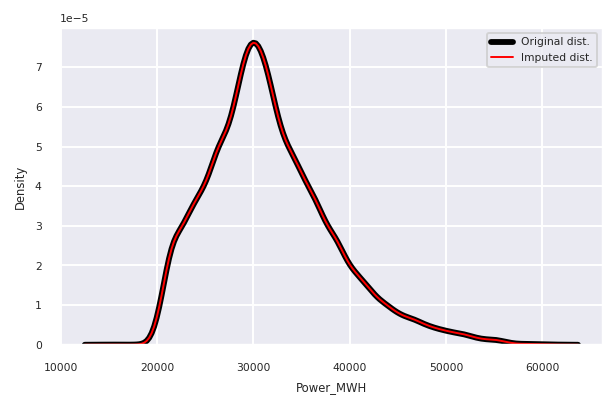

,Imputed_Power_MWH
Datetime,
2010-01-01 00:00:00,31647.0
2010-01-01 01:00:00,30075.0
2010-01-01 02:00:00,28907.0
2010-01-01 03:00:00,27906.0
2010-01-01 04:00:00,27373.0
...,...
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0
2018-08-02 22:00:00,41552.0


In [ ]:
preprocessed_df = preprocessing(dataset)
preprocessed_df

# Data Analysis 



In this section we focus on data analysis. 
Since we have a time series data we checked for:

*  Seasonality: To check for any regular and predictable changes that recur. It is better to remove the seasonality to increase the degrees of freedom and independency. In this assignment we did not reduce the seasonality do to the lack of time.
*   Autocorrolation: To check for any random noise or white noise. We make an autocorrelation plot to compare the values of the autocorrelation function (AFC) against different lag sizes. As it is shown, the data is highly corrolated when we set lag=1 and decreases graduallt till the lag=12, which is as we expected since the power is less consumed during the night compare with daytime. Furthuremore, as the lag increses to 24 we see a gradual increase the the corrolation.
*  Stationary: To check if data properties do not depend on the time.  Lets think about flipping a coin, being stationary in timeseries is really important, due to the fact that we want filliping the coin to be independent of time.

<br>
<br>

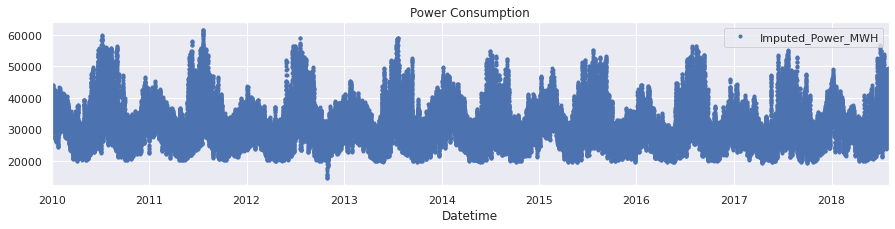

In [ ]:
preprocessed_df.plot(style='.', figsize=(15,3), title='Power Consumption')
plt.show()

In [ ]:
# Seasonality check

analysis = preprocessed_df[['Imputed_Power_MWH']].copy()


decompose_result_mult = seasonal_decompose(analysis, model="multiplicative", period=24)


# trend = decompose_result_mult.trend
# seasonal = decompose_result_mult.seasonal
# residual = decompose_result_mult.resid

decompose_result_mult.seasonal.describe()

count    75265.000000
mean         0.999999
std          0.113697
min          0.799668
25%          0.923185
50%          1.040582
75%          1.081608
max          1.133737
Name: seasonal, dtype: float64

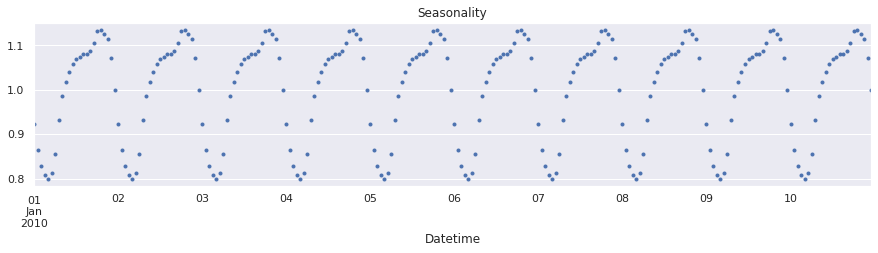

In [ ]:
decompose_result_mult.seasonal[:240].plot(style='.', figsize=(15,3), title='Seasonality')

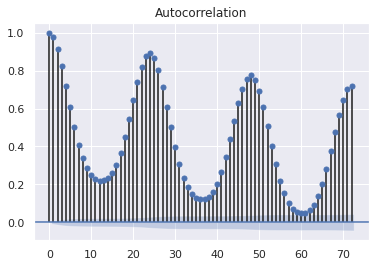

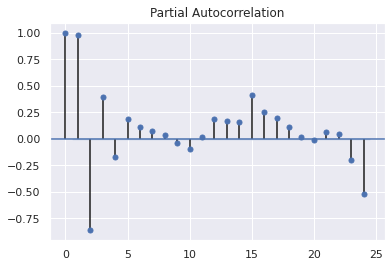

In [ ]:
# Use the Autocorrelation function from the statsmodel library passing our DataFrame object in as the data
# Note: Limiting Lags to 24
plot_acf(preprocessed_df, lags=72)
# Show the AR as a plot
plt.show()

plot_pacf(preprocessed_df, lags=24, method = "ols")
# Show the AR as a plot
plt.show()

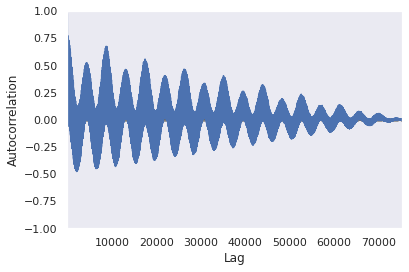

In [ ]:
autocorrelation_plot(preprocessed_df)
plt.show()

In [ ]:
def plot_shifts_and_lags(df, max_diff):
  columns = []
  for i in [1,2,3,12,24]:
    df["shifted_diff_"+str(i)] = df["Imputed_Power_MWH"].shift(i)
    columns.append("shifted_diff_"+str(i))
  df.plot(figsize=(16, 18), subplots=True)
  plt.show()

  correlation = df.corr()
  sns.heatmap(correlation, annot=True, fmt='.2f', cmap='RdYlGn')



  df.drop(columns, axis=1, inplace=True)


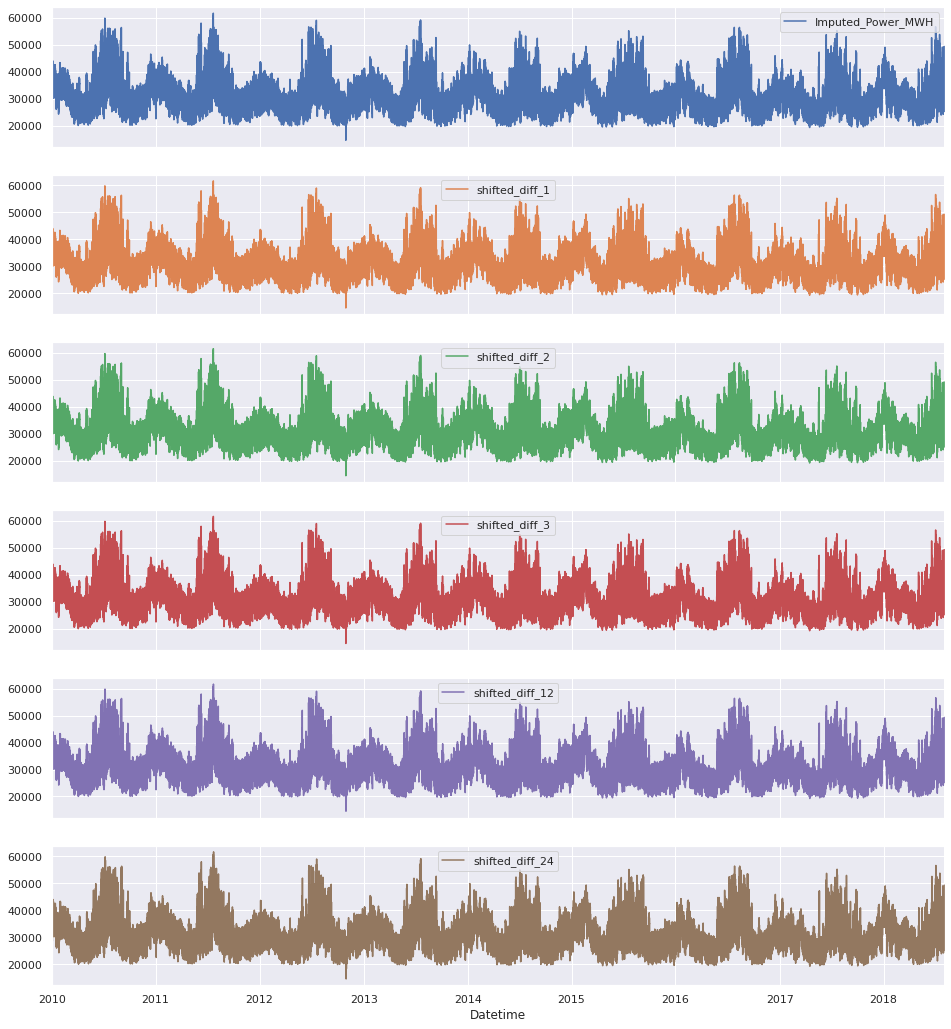

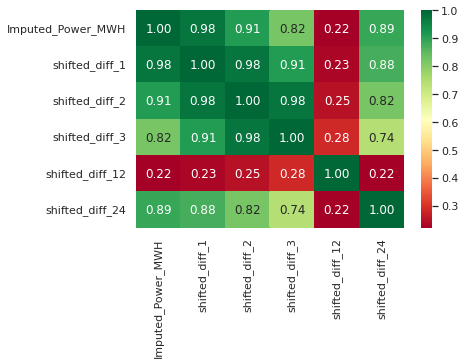

In [ ]:
plot_shifts_and_lags(preprocessed_df, max_diff=25)

In [ ]:
def test_stationarity(ts_data, column='', signif=0.05, series=False):
    if series:
        adf_test = adfuller(ts_data, autolag='AIC')
    else:
        adf_test = adfuller(ts_data[column], autolag='AIC')
    p_value = adf_test[1]
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    return test_result
print(test_stationarity(preprocessed_df, column='Imputed_Power_MWH'))

Stationary


\# Anomaly Detection 

**Anomalies** are the data points that deviate significantly from the general behaviour of the data. Detecting anomalies in the data can be much useful before training. Since our data contain only one feature and a timestamp column associated with it, we used **Univarite Anomaly Detection** explained in this [blog](https://www.analyticsvidhya.com/blog/2021/08/univariate-time-series-anomaly-detection-using-arima-model/). <br>

We took a few steps to find the anomalies and replace them with some other values:

*   Fit the **ARIMA** model and find the squared errors.
*   Find the **threshold** using squared errors.
*   The errors **above the threshold** are considered to be anomalous data.
*   **Replace** the anomalous data with the values calculated by ARIMA. 

<br>
<br>

In [ ]:
max_p, max_q = 5, 5 
def get_order_sets(n, n_per_set) -> list:
    n_sets = [i for i in range(n)]
    order_sets = [
        n_sets[i:i + n_per_set]
        for i in range(1, n, n_per_set)
    ]
    return order_sets
def find_aic_for_model(data, p, q, model, model_name):
    # try:
        msg = f"Fitting {model_name} with order p, q = {p, 1, q}n"
        print(msg)
        if p == 0 and q == 1:
            # since p=0 and q=1 is already
            # calculated
            return None, (p, 1, q)
        ts_results = model(data, order=(p, 1, q)).fit()
        curr_aic = ts_results.aic
        return curr_aic, (p, 1, q)
    # except Exception as e:
    #     f"""Exception occurred continuing {e}"""
    #     return None, (p, 1, q)
def find_best_order_for_model(data, model, model_name):
    p_ar, q_ma = max_p, max_q
    final_results = []
    ts_results = model(data, order=(1, 1, 1)).fit()
    min_aic = ts_results.aic
    final_results.append((min_aic, (1, 1, 1)))
    # example if q_ma is 6
    # order_sets would be [[0, 1, 2, 3, 4], [5]]
    order_sets = get_order_sets(q_ma, 5)
    for p in range(1, p_ar):
        for order_set in order_sets:
            # fit the model and find the aic
            for q in order_set:
                results = find_aic_for_model(data, p, q, model, model_name)
                
                final_results.append(results)
    print(final_results)
    results_df = pd.DataFrame(
        final_results,
        columns=['aic', 'order']
    )
    min_df = results_df[
        results_df['aic'] == results_df['aic'].min()
    ]
    min_aic = min_df['aic'].iloc[0]
    min_order = min_df['order'].iloc[0]
    return min_aic, min_order, results_df
min_aic, min_order, results_df = find_best_order_for_model(
    preprocessed_df, ARIMA, "ARMA"
)
print(min_aic, min_order)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Fitting ARMA with order p, q = (1, 1, 1)n


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Fitting ARMA with order p, q = (1, 1, 2)n


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Fitting ARMA with order p, q = (1, 1, 3)n


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Fitting ARMA with order p, q = (1, 1, 4)n


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Fitting ARMA with order p, q = (2, 1, 1)n


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Fitting ARMA with order p, q = (2, 1, 2)n


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invert

Fitting ARMA with order p, q = (2, 1, 3)n


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Fitting ARMA with order p, q = (2, 1, 4)n


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting ARMA with order p, q = (3, 1, 1)n


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Fitting ARMA with order p, q = (3, 1, 2)n


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Fitting ARMA with order p, q = (3, 1, 3)n


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting ARMA with order p, q = (3, 1, 4)n


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting ARMA with order p, q = (4, 1, 1)n


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Fitting ARMA with order p, q = (4, 1, 2)n


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Fitting ARMA with order p, q = (4, 1, 3)n


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting ARMA with order p, q = (4, 1, 4)n


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[(1192351.036182341, (1, 1, 1)), (1192351.036182341, (1, 1, 1)), (1191316.7108639136, (1, 1, 2)), (1191287.2507656894, (1, 1, 3)), (1190849.0284971972, (1, 1, 4)), (1191093.6960910044, (2, 1, 1)), (1181058.0954642107, (2, 1, 2)), (1180693.6741575294, (2, 1, 3)), (1179484.1278375913, (2, 1, 4)), (1190885.7250504815, (3, 1, 1)), (1180874.5168068158, (3, 1, 2)), (1175487.2048966691, (3, 1, 3)), (1178735.6570621156, (3, 1, 4)), (1179853.7562520364, (4, 1, 1)), (1185419.414343465, (4, 1, 2)), (1179631.3564966533, (4, 1, 3)), (1174386.2803892903, (4, 1, 4))]
1174386.2803892903 (4, 1, 4)


In [ ]:
def find_anomalies(squared_errors):
    threshold = np.mean(squared_errors) + np.std(squared_errors)
    predictions = (squared_errors >= threshold).astype(int)
    return predictions, threshold


In [ ]:
min_order = (4,1,4)
arima = ARIMA(preprocessed_df, order=min_order)
arima_fit = arima.fit()
squared_errors = arima_fit.resid ** 2
predictions, threshold = find_anomalies(squared_errors)
forecast = arima_fit.predict()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
preprocessed_df['anomaly'] = predictions
preprocessed_df['forecast'] = forecast

preprocessed_df

,Imputed_Power_MWH,anomaly,forecast
Datetime,,,
2010-01-01 00:00:00,31647.0,1,0.000000
2010-01-01 01:00:00,30075.0,1,49959.996857
2010-01-01 02:00:00,28907.0,1,22727.578652
2010-01-01 03:00:00,27906.0,0,29367.703367
2010-01-01 04:00:00,27373.0,1,24354.998698
...,...,...,...
2018-08-02 20:00:00,44057.0,0,43951.198153
2018-08-02 21:00:00,43256.0,0,42586.976596
2018-08-02 22:00:00,41552.0,0,42657.823845


In [ ]:
fig = px.line(preprocessed_df, x=preprocessed_df.index, y="Imputed_Power_MWH", title='Power Consumption - UNSUPERVISED ANOMALY DETECTION', template = 'plotly_dark')
# create list of outlier_dates
outlier_dates = preprocessed_df[preprocessed_df['anomaly'] == 1].index
# obtain y value of anomalies to plot
y_values = [preprocessed_df.loc[i]['Imputed_Power_MWH'] for i in outlier_dates]
fig.add_trace(go.Scatter(x=outlier_dates, y=y_values, mode = 'markers', 
                name = 'anomaly', 
                marker=dict(color='red',size=10)))
        
fig.show()

In [ ]:
preprocessed_df.loc['2010-01-01 00:00:00', 'anomaly'] = 0
preprocessed_df.loc[preprocessed_df['anomaly'] == 1,'Imputed_Power_MWH'] = preprocessed_df.loc[preprocessed_df['anomaly'] == 1,'forecast'] 

In [ ]:
preprocessed_df

,Imputed_Power_MWH,anomaly,forecast
Datetime,,,
2010-01-01 00:00:00,31647.000000,0,0.000000
2010-01-01 01:00:00,49959.996857,1,49959.996857
2010-01-01 02:00:00,22727.578652,1,22727.578652
2010-01-01 03:00:00,27906.000000,0,29367.703367
2010-01-01 04:00:00,24354.998698,1,24354.998698
...,...,...,...
2018-08-02 20:00:00,44057.000000,0,43951.198153
2018-08-02 21:00:00,43256.000000,0,42586.976596
2018-08-02 22:00:00,41552.000000,0,42657.823845


In [ ]:
preprocessed_df.drop(['anomaly', 'forecast'], axis=1, inplace = True)
preprocessed_df

,Imputed_Power_MWH
Datetime,
2010-01-01 00:00:00,31647.000000
2010-01-01 01:00:00,49959.996857
2010-01-01 02:00:00,22727.578652
2010-01-01 03:00:00,27906.000000
2010-01-01 04:00:00,24354.998698
...,...
2018-08-02 20:00:00,44057.000000
2018-08-02 21:00:00,43256.000000
2018-08-02 22:00:00,41552.000000


# Modeling

1.   Feature engineering
2.   Data windowing
3.   Models
  *   Repeat baseline
  *   ARIMA baseline
  *   Linear model
  *   Dense Neural Network
  *   Convolutional Neural Network
  *   Long-Short Term Memory (LSTM)
  *   AutoRegressive Long-Short Term Memory (AR-LSTM)
4.   Performances
5. Hyper-parameter Tuning











## Feature engineering

**Date time features** are features created from the time stamp value of each row. Using these new generated features we can build a better model for time series forecasting. A few examples of these features are:

*   Hour of the day
*   Day of the week
*   Season of the year 
*   Month of the year
*   Year
*   Day of the year
*   Day of the month
*   Week of the year

We added these features and **splitted** the data to **train**, **validation** and **test** using:



*   Validation split date: '2017-01-01 00:00:00'
*   Test split date: '2018-01-01 00:00:00'

We **normalized** data using the **mean** and **standard deviation** of the train data. Then we visualized the distribution of features and skewness through **box plots**. 

<br>
<br>


In [ ]:
test_split = '2018-01-01 00:00:00'
val_split = '2017-01-01 00:00:00'
train = preprocessed_df.loc[:val_split,:].copy()
val = preprocessed_df.loc[val_split:test_split,:].copy()
test = preprocessed_df.loc[test_split:,:].copy()

In [ ]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df.drop('date', axis=1, inplace=True)

    return df

In [ ]:
train_df = create_features(train)
val_df = create_features(val)
test_df = create_features(test)

<ipython-input-35-1c9c13ce256b>:13: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [ ]:
# Normalize Data
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

<ipython-input-35-1c9c13ce256b>:13: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



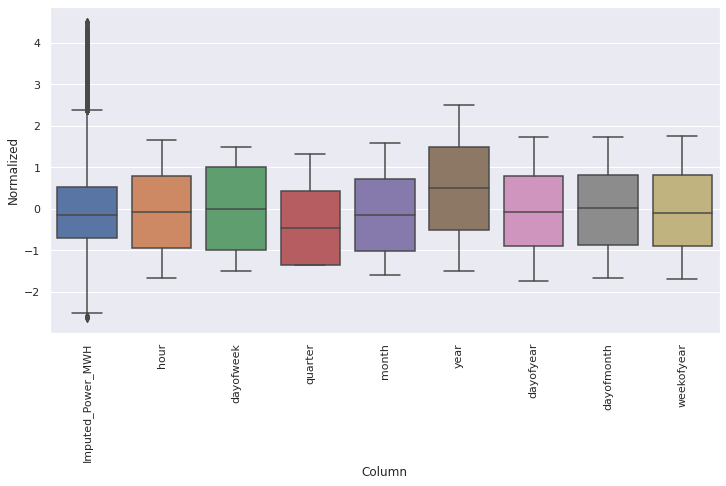

In [ ]:
df = create_features(preprocessed_df)
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.boxplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data windowing

We should **create windows of consecutive samples** from the data in order to build better a better model for time series forcasting.

The main features of the input windows are:



*   The width (number of time steps) of the input and label windows.
*   The time offset between them.
*   Which features are used as inputs, labels, or both.

We define a **WindowGenerator** class. It takes the training, evaluation, and test DataFrames as inputs and converts them to tf.data.Datasets of windows later. The **split_window** method which can convert them to a window of inputs and a window of labels. Finally, **make_dataset** method will take a time series DataFrame and convert it to a tf.data.Dataset of **(input_window, label_window)** pairs.

We made use of this [Tensorflow blog](https://www.tensorflow.org/tutorials/structured_data/time_series#single-shot_models) to define window generator. 

<br>
<br>


In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)
    
  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.test))
    print('result:', result[0].shape)
    print('---------------------------------')
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example


In [ ]:
# The plot method that allows a simple visualization of the split window.

def plot(self, model=None, plot_col='Imputed_Power_MWH', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col}')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

result: (32, 24, 9)
---------------------------------


Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['Imputed_Power_MWH']

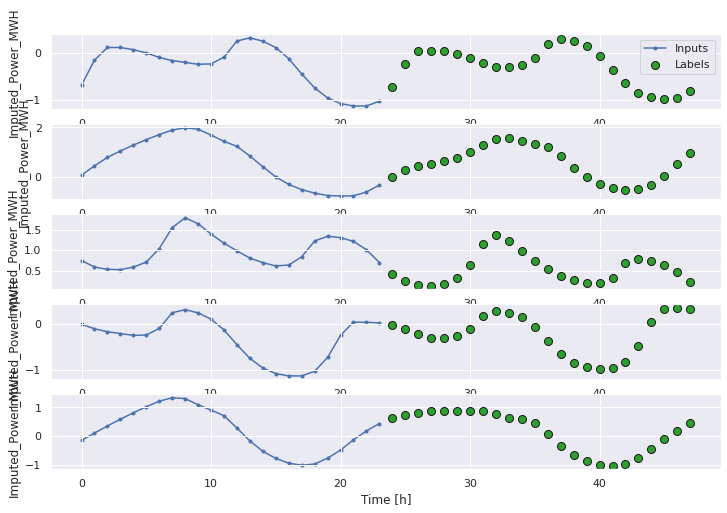

In [ ]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=['Imputed_Power_MWH'])

multi_window.plot(max_subplots=5)
multi_window

## Models

### Baseline

**Repeat baseline**

A very naive baseline for this task is to repeat the previous day, assuming tomorrow will be similar:

273/273 [==============================] - 1s 4ms/step - loss: 1.9959 - mean_absolute_error: 1.1262


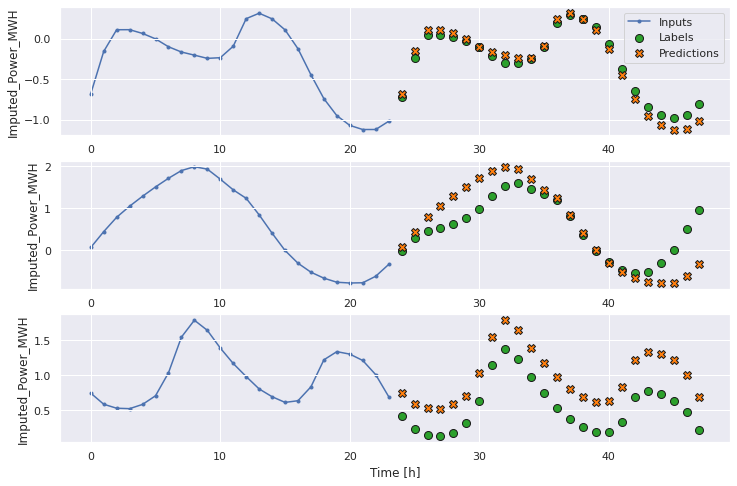

In [ ]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)[1]
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)[1]
multi_window.plot(repeat_baseline)

**ARIMA baseline**

The second simple baseline for this task could be a statistical model called **ARIMA**. It is an acronym that stands for **AutoRegressive Integrated Moving Average**. It is a generalization of the simpler AutoRegressive Moving Average and adds the notion of integration. This method requires three parameters p,q and d. "P" is The number of lag observations included in the model (lag order). "d" is the number of times that the raw observations are differenced (degree of differencing). "q" is the size of the moving average window (order of moving average).
 There are couple of other methods that we can try such as Exponential Moving Average (EMA) and Simple Moving Average (SMA). In this assignmet we only focues on ARIMA.

In [ ]:
min_order = (4,1,4) # Calculated from the anomaly detection part
arima_model = ARIMA(train_df.Imputed_Power_MWH, order=min_order)
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

val_pred = arima_model_fit.predict(start=val_df.Imputed_Power_MWH.index[0], end=val_df.Imputed_Power_MWH.index[-1])
val_mae = mean_absolute_error(val_df.Imputed_Power_MWH, val_pred)
test_pred = arima_model_fit.predict(start=test_df.Imputed_Power_MWH.index[0], end=test_df.Imputed_Power_MWH.index[-1])
test_mae = mean_absolute_error(test_df.Imputed_Power_MWH, test_pred)


multi_val_performance['ARIMA'] = val_mae
multi_performance['ARIMA'] = test_mae


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated a

### Single-shot models

There are two rough approaches for this task:

* Single shot predictions where the entire time series is predicted at once.
* Autoregressive predictions where the model only makes single step predictions and its output is fed back as its input.

We are going to use "single-shot" models first, where the model makes the entire sequence prediction in a single step.

In [ ]:
# Summerizing the training procedure into a function

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

**Linear:**

A simple linear model based on the last input time step does better than either baseline, but is underpowered. The model needs to predict OUTPUT_STEPS time steps, from a single input time step with a linear projection. It can only capture a low-dimensional slice of the behavior, likely based mainly on the time of day and time of year.

Epoch 1/20
1917/1917 [==============================] - 10s 5ms/step - loss: 0.6048 - mean_absolute_error: 0.5930 - val_loss: 0.4588 - val_mean_absolute_error: 0.5180
Epoch 2/20
1917/1917 [==============================] - 10s 5ms/step - loss: 0.5255 - mean_absolute_error: 0.5491 - val_loss: 0.4586 - val_mean_absolute_error: 0.5176
Epoch 3/20
1917/1917 [==============================] - 9s 5ms/step - loss: 0.5255 - mean_absolute_error: 0.5491 - val_loss: 0.4586 - val_mean_absolute_error: 0.5175
Epoch 4/20
1917/1917 [==============================] - 10s 5ms/step - loss: 0.5255 - mean_absolute_error: 0.5491 - val_loss: 0.4582 - val_mean_absolute_error: 0.5173
Epoch 5/20
1917/1917 [==============================] - 12s 6ms/step - loss: 0.5255 - mean_absolute_error: 0.5491 - val_loss: 0.4591 - val_mean_absolute_error: 0.5180
Epoch 6/20
273/273 [==============================] - 1s 4ms/step - loss: 0.4583 - mean_absolute_error: 0.5173


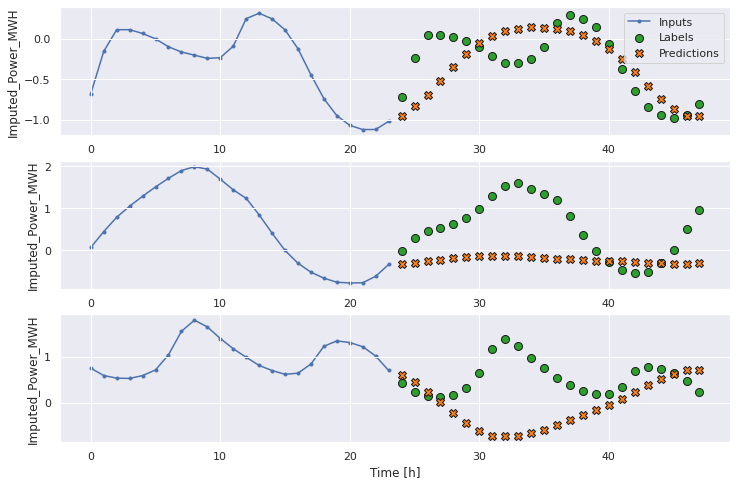

In [ ]:
num_features = 9
MAX_EPOCHS = 20
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)[1]
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)[1]
multi_window.plot(multi_linear_model)

**Dense**

Adding a tf.keras.layers.Dense between the input and output gives the linear model more power, but is still only based on a single input time step.

Epoch 1/20
1917/1917 [==============================] - 24s 12ms/step - loss: 0.2664 - mean_absolute_error: 0.3862 - val_loss: 0.1556 - val_mean_absolute_error: 0.3002
Epoch 2/20
1917/1917 [==============================] - 21s 11ms/step - loss: 0.1340 - mean_absolute_error: 0.2762 - val_loss: 0.1289 - val_mean_absolute_error: 0.2677
Epoch 3/20
1917/1917 [==============================] - 21s 11ms/step - loss: 0.1121 - mean_absolute_error: 0.2502 - val_loss: 0.1187 - val_mean_absolute_error: 0.2538
Epoch 4/20
1917/1917 [==============================] - 23s 12ms/step - loss: 0.1018 - mean_absolute_error: 0.2368 - val_loss: 0.1149 - val_mean_absolute_error: 0.2475
Epoch 5/20
1917/1917 [==============================] - 17s 9ms/step - loss: 0.0964 - mean_absolute_error: 0.2292 - val_loss: 0.1125 - val_mean_absolute_error: 0.2473
Epoch 6/20
1917/1917 [==============================] - 19s 10ms/step - loss: 0.0935 - mean_absolute_error: 0.2255 - val_loss: 0.1125 - val_mean_absolute_error: 

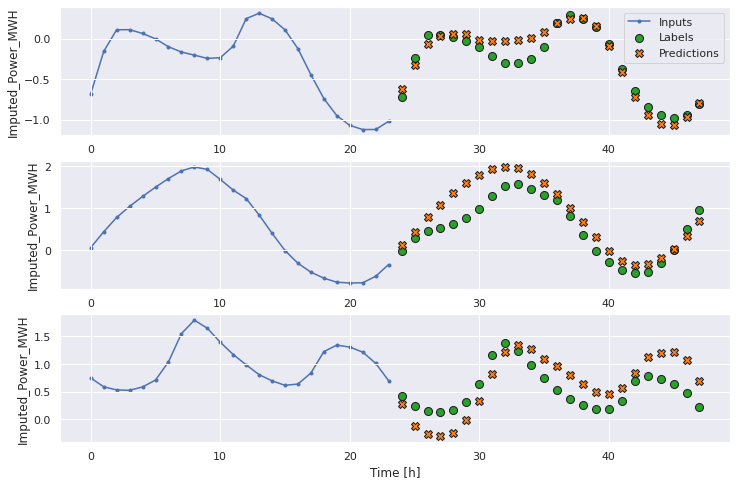

In [ ]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)[1]
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)[1]
multi_window.plot(multi_dense_model)

**CNN**

A convolutional model makes predictions based on a fixed-width history, which may lead to better performance than the dense model since it can see how things are changing over time:

Epoch 1/20
1917/1917 [==============================] - 22s 11ms/step - loss: 0.2234 - mean_absolute_error: 0.3513 - val_loss: 0.1483 - val_mean_absolute_error: 0.2870
Epoch 2/20
1917/1917 [==============================] - 21s 11ms/step - loss: 0.1216 - mean_absolute_error: 0.2598 - val_loss: 0.1263 - val_mean_absolute_error: 0.2642
Epoch 3/20
1917/1917 [==============================] - 20s 10ms/step - loss: 0.1061 - mean_absolute_error: 0.2412 - val_loss: 0.1154 - val_mean_absolute_error: 0.2493
Epoch 4/20
1917/1917 [==============================] - 21s 11ms/step - loss: 0.1001 - mean_absolute_error: 0.2332 - val_loss: 0.1114 - val_mean_absolute_error: 0.2443
Epoch 5/20
1917/1917 [==============================] - 22s 11ms/step - loss: 0.0968 - mean_absolute_error: 0.2284 - val_loss: 0.1125 - val_mean_absolute_error: 0.2481
Epoch 6/20
1917/1917 [==============================] - 17s 9ms/step - loss: 0.0941 - mean_absolute_error: 0.2245 - val_loss: 0.1045 - val_mean_absolute_error: 

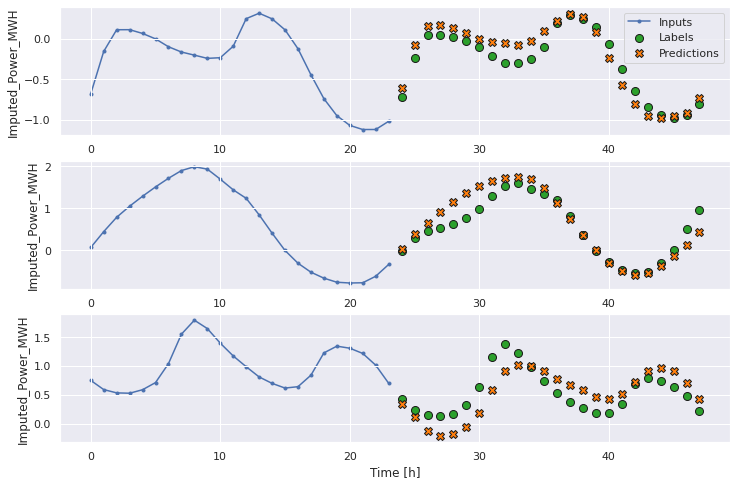

In [ ]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)


multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)[1]
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)[1]
multi_window.plot(multi_conv_model)

**LSTM**

A recurrent model can learn to use a long history of inputs, if it's relevant to the predictions the model is making. Here the model will accumulate internal state for 24 hours, before making a single prediction for the next 24 hours.

Epoch 1/20
1917/1917 [==============================] - 38s 18ms/step - loss: 0.1958 - mean_absolute_error: 0.3227 - val_loss: 0.1092 - val_mean_absolute_error: 0.2472
Epoch 2/20
1917/1917 [==============================] - 29s 15ms/step - loss: 0.0889 - mean_absolute_error: 0.2183 - val_loss: 0.0949 - val_mean_absolute_error: 0.2260
Epoch 3/20
1917/1917 [==============================] - 29s 15ms/step - loss: 0.0801 - mean_absolute_error: 0.2051 - val_loss: 0.0916 - val_mean_absolute_error: 0.2220
Epoch 4/20
1917/1917 [==============================] - 29s 15ms/step - loss: 0.0760 - mean_absolute_error: 0.1989 - val_loss: 0.0878 - val_mean_absolute_error: 0.2155
Epoch 5/20
1917/1917 [==============================] - 31s 16ms/step - loss: 0.0735 - mean_absolute_error: 0.1949 - val_loss: 0.0847 - val_mean_absolute_error: 0.2102
Epoch 6/20
1917/1917 [==============================] - 29s 15ms/step - loss: 0.0718 - mean_absolute_error: 0.1922 - val_loss: 0.0859 - val_mean_absolute_error:

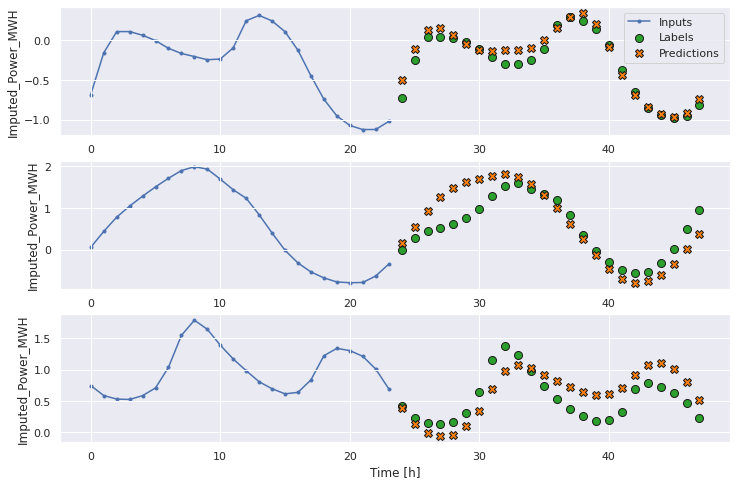

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)


multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)[1]
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)[1]
multi_window.plot(multi_lstm_model)

**Auto Regressive LSTM**

In some cases it may be helpful for the model to decompose this prediction into individual time steps. Then, each model's output can be fed back into itself at each step and predictions can be made conditioned on the previous one. 

One clear advantage to this style of model is that it can be set up to produce output with a varying length.

In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [ ]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [ ]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

This method returns a single time-step prediction and the internal state of the LSTM:

In [ ]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 9])

With the RNN's state, and an initial prediction you can now continue iterating the model feeding the predictions at each step back as the input.

In [ ]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [ ]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 9)


Epoch 1/20
1917/1917 [==============================] - 45s 21ms/step - loss: 0.2127 - mean_absolute_error: 0.3444 - val_loss: 0.1495 - val_mean_absolute_error: 0.2940
Epoch 2/20
1917/1917 [==============================] - 38s 20ms/step - loss: 0.1144 - mean_absolute_error: 0.2525 - val_loss: 0.1137 - val_mean_absolute_error: 0.2521
Epoch 3/20
1917/1917 [==============================] - 41s 21ms/step - loss: 0.0974 - mean_absolute_error: 0.2299 - val_loss: 0.1108 - val_mean_absolute_error: 0.2453
Epoch 4/20
1917/1917 [==============================] - 39s 20ms/step - loss: 0.0895 - mean_absolute_error: 0.2184 - val_loss: 0.0976 - val_mean_absolute_error: 0.2283
Epoch 5/20
1917/1917 [==============================] - 39s 20ms/step - loss: 0.0843 - mean_absolute_error: 0.2106 - val_loss: 0.0956 - val_mean_absolute_error: 0.2246
Epoch 6/20
1917/1917 [==============================] - 39s 20ms/step - loss: 0.0805 - mean_absolute_error: 0.2049 - val_loss: 0.0953 - val_mean_absolute_error:

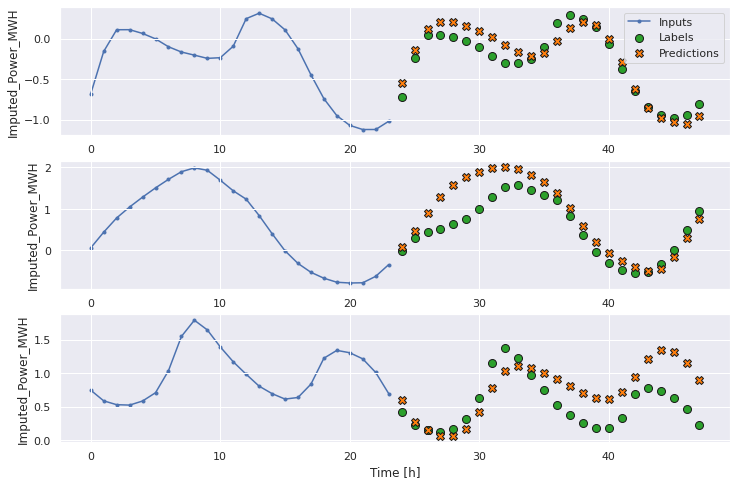

In [ ]:
history = compile_and_fit(feedback_model, multi_window)


multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)[1]
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)[1]
multi_window.plot(feedback_model)

## Performance

To evalaute our models, we use  Mean Absolute Error (MAE). The validation and test perfomances for all the models are shown in the bar chart below. 

[1.126169204711914, 0.7208971479147998, 0.5172939896583557, 0.2442183643579483, 0.22765293717384338, 0.20269297063350677, 0.2224147766828537]
[1.1293330192565918, 0.7383302913957955, 0.5362149477005005, 0.27882155776023865, 0.2575583755970001, 0.24074214696884155, 0.2600476145744324]


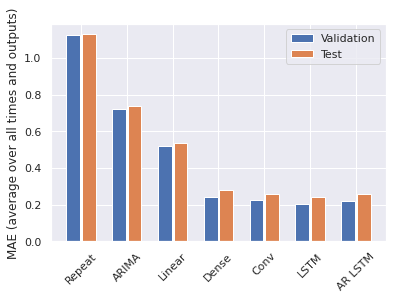

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3

# metric_name = 'mean_absolute_error'
# metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v for v in multi_val_performance.values()]
test_mae = [v for v in multi_performance.values()]
print(val_mae)
print(test_mae)

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [ ]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value:0.4f}')

Repeat  : 1.1293
ARIMA   : 0.7383
Linear  : 0.5362
Dense   : 0.2788
Conv    : 0.2576
LSTM    : 0.2407
AR LSTM : 0.2600


**Conclusion:**
Model perfomances improved from the dense model to convolutional and recurrent models. 
The autoregressive LSTM model performed worse compared with single shot LSTM model, So these more complex approaches may not be worth specifically when we want to deploy the model in production and latency is a critical factor for us.  Furthermore, we can see that ARIMA and Reapet models have really poor performance in both validation and testing phases.

## Hyperparameter Tuning

In this section we try to train our single layer model with multiple hyperparameters to find the best perfomance model.

In [ ]:
lstm_unit = 10
timestep = 48
print(f'Training LSTM with, {lstm_unit} units and considering {int(timestep/24)} days ago!')

Training LSTM with, 10 units and considering 2 days ago!


In [ ]:
possibleHyperParameters = [[16,24],[64,48],[256,96],[16,96],[256,24]]
hist = []
final_val_performances = []
min_val_performance = np.inf
for parameters in possibleHyperParameters:
  lstm_unit,timestep = parameters
  print(f'Training LSTM with, {lstm_unit} units and considering {int(timestep/24)} days ago!')
  multi_window = WindowGenerator(input_width=timestep,
                               label_width=24,
                               shift=24,
                               label_columns=['Imputed_Power_MWH'])
  final_lstm_model = tf.keras.Sequential([
      # Shape [batch, time, features] => [batch, lstm_units].
      # Adding more `lstm_units` just overfits more quickly.
      tf.keras.layers.LSTM(lstm_unit, return_sequences=False),
      # Shape => [batch, out_steps*features].
      tf.keras.layers.Dense(OUT_STEPS*num_features,
                            kernel_initializer=tf.initializers.zeros()),
      # Shape => [batch, out_steps, features].
      tf.keras.layers.Reshape([OUT_STEPS, num_features])
  ])

  history = compile_and_fit(final_lstm_model, multi_window)

  # IPython.display.clear_output()
  val_perdormance = final_lstm_model.evaluate(multi_window.val)[1]
  final_val_performances.append(val_perdormance)
  if val_perdormance < min_val_performance:
    min_val_performance = val_perdormance
    best_lstm_model = final_lstm_model




Training LSTM with, 16 units and considering 1 days ago!
Epoch 1/20
1917/1917 [==============================] - 32s 15ms/step - loss: 0.2593 - mean_absolute_error: 0.3777 - val_loss: 0.1339 - val_mean_absolute_error: 0.2763
Epoch 2/20
1917/1917 [==============================] - 27s 14ms/step - loss: 0.1093 - mean_absolute_error: 0.2460 - val_loss: 0.1079 - val_mean_absolute_error: 0.2432
Epoch 3/20
1917/1917 [==============================] - 27s 14ms/step - loss: 0.0932 - mean_absolute_error: 0.2232 - val_loss: 0.0983 - val_mean_absolute_error: 0.2270
Epoch 4/20
1917/1917 [==============================] - 28s 15ms/step - loss: 0.0864 - mean_absolute_error: 0.2132 - val_loss: 0.0931 - val_mean_absolute_error: 0.2217
Epoch 5/20
1917/1917 [==============================] - 29s 15ms/step - loss: 0.0828 - mean_absolute_error: 0.2080 - val_loss: 0.0900 - val_mean_absolute_error: 0.2180
Epoch 6/20
1917/1917 [==============================] - 27s 14ms/step - loss: 0.0805 - mean_absolute_er

test_MAE:  0.3074272572994232
validation_MAE:  0.2689000368118286
result: (32, 24, 9)
---------------------------------


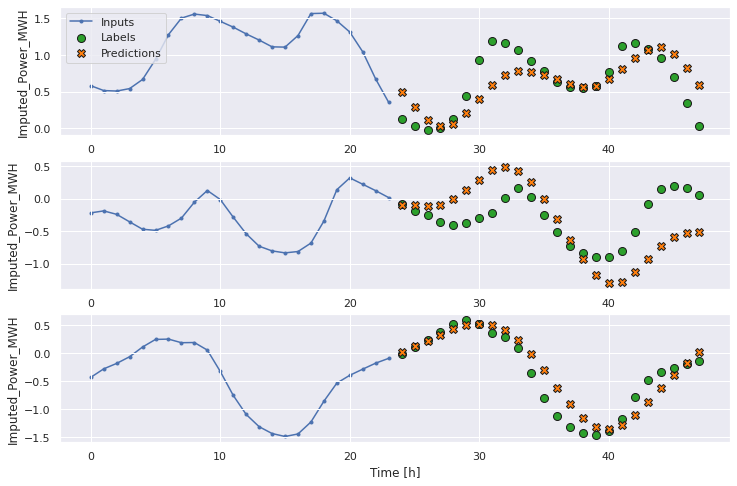

In [ ]:
test_mae=best_lstm_model.evaluate(multi_window.test, verbose=0)[1]
val_mae=best_lstm_model.evaluate(multi_window.val, verbose=0)[1]
print('test_MAE: ', test_mae)
print('validation_MAE: ', val_mae)
multi_window.plot(best_lstm_model)

In [ ]:
best_lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                18944     
                                                                 
 dense_7 (Dense)             (None, 216)               14040     
                                                                 
 reshape_5 (Reshape)         (None, 24, 9)             0         
                                                                 
Total params: 32,984
Trainable params: 32,984
Non-trainable params: 0
_________________________________________________________________


**Conclusion:**

Although in this assignment the model training is not required, we tried some approaches to a time series problem, we have developed different models, applied data preprocessing steps, this is not meant that have a great performance,  we can to try a few different hyper-parameters, such as batch sizes and diffent opimizers such as RMSprop, and different networks topologies. 

